### Деревья решений и ансамбли (bagging / random forest / boosting / stacking) и честный ML-эксперимент 
###

In [23]:
import os
import json
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

sns.set(style="whitegrid")
RANDOM_STATE = 42

Файл загружен: c:\По учебе\ЦФ\aie-group-3\homeworks\HW06\S06-hw-dataset-04.csv
Размер датасета: (25000, 62)


,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,target
0,1,-1.250210,1.423474,-0.225004,-4.023138,-0.832729,-0.550874,1.772090,2.761690,-0.698750,...,10.938269,0.501178,1.600001,0.314212,1.209735,1.355697,-5.338924,1.153944,-0.153934,0
1,2,0.074328,0.376429,0.212831,-0.502074,2.017405,0.625496,1.943785,1.242030,-0.524090,...,7.775262,-4.550195,6.272586,-0.932162,-0.228543,1.735220,-3.827828,0.292165,0.273720,0
2,3,0.638481,0.060968,0.746760,2.479653,-0.292858,-0.078139,-2.918423,-0.013186,1.009135,...,-4.448447,-9.593179,-3.093519,0.029321,0.605511,0.829103,-0.085985,2.891408,0.766221,0
3,4,1.712916,-1.350969,-0.256473,1.622074,-0.445141,0.911932,-3.440345,1.505192,-1.104348,...,-1.619072,-3.237479,-5.474038,-1.582475,0.198137,3.823409,0.880395,1.148610,0.136732,0
4,5,0.905676,-0.206545,-0.068806,4.086026,-1.010045,-0.772644,-4.207688,2.506104,1.589143,...,-2.396844,-10.540129,-5.532811,-1.231203,0.000119,4.298572,-1.558235,0.924673,0.111668,0



Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 62 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      25000 non-null  int64  
 1   f01     25000 non-null  float64
 2   f02     25000 non-null  float64
 3   f03     25000 non-null  float64
 4   f04     25000 non-null  float64
 5   f05     25000 non-null  float64
 6   f06     25000 non-null  float64
 7   f07     25000 non-null  float64
 8   f08     25000 non-null  float64
 9   f09     25000 non-null  float64
 10  f10     25000 non-null  float64
 11  f11     25000 non-null  float64
 12  f12     25000 non-null  float64
 13  f13     25000 non-null  float64
 14  f14     25000 non-null  float64
 15  f15     25000 non-null  float64
 16  f16     25000 non-null  float64
 17  f17     25000 non-null  float64
 18  f18     25000 non-null  float64
 19  f19     25000 non-null  float64
 20  f20     25000 non-null  float64
 21  f21     25000 non-null  floa

C:\Users\MaRiN\AppData\Local\Temp\ipykernel_20304\3852639428.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df, palette='viridis')


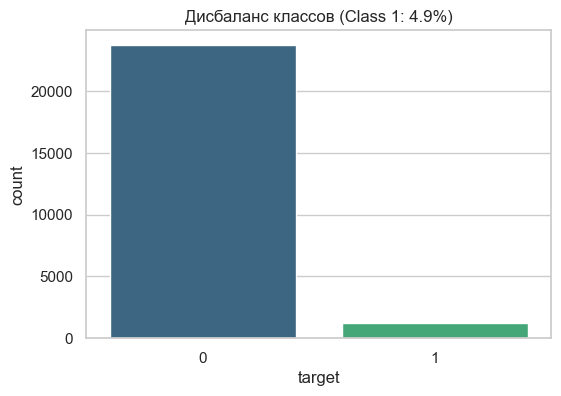

In [24]:
filename = "S06-hw-dataset-04.csv"

file_path = os.path.join(os.getcwd(), filename)

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print(f"Файл загружен: {file_path}")
    
    print(f"Размер датасета: {df.shape}")
    display(df.head())
    print("\nИнфо:")
    df.info()

    print("\nБаланс классов:")     # Распределение таргета (проверка дисбаланса)
    target_counts = df['target'].value_counts(normalize=True)
    print(target_counts)

    plt.figure(figsize=(6, 4))
    sns.countplot(x='target', data=df, palette='viridis')
    plt.title(f"Дисбаланс классов (Class 1: {target_counts[1]:.1%})")
    plt.savefig("artifacts/figures/target_distribution.png")
    plt.show()
    
else:
    print(f"Файл '{file_path}' не найден")

In [25]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape:  {X_test.shape}")

Train shape: (18750, 61)
Test shape:  (6250, 61)


In [26]:
# Словарь для хранения результатов
metrics_storage = {}

def evaluate_model(name, model, X_te, y_te, y_pred, y_prob=None):
    """Вспомогательная функция для подсчета метрик"""
    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred)
    roc = roc_auc_score(y_te, y_prob) if y_prob is not None else 0.5
    
    metrics_storage[name] = {
        "accuracy": round(acc, 4),
        "f1": round(f1, 4),
        "roc_auc": round(roc, 4)
    }
    print(f"Model: {name} | Acc: {acc:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f}")

# Dummy Classifier (Константный прогноз)
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
y_prob_dummy = dummy.predict_proba(X_test)[:, 1]
evaluate_model("Dummy", dummy, X_test, y_test, y_pred_dummy, y_prob_dummy)

# Logistic Regression (Линейный бейзлайн)
logreg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(random_state=RANDOM_STATE))
])
logreg_pipe.fit(X_train, y_train)
y_pred_lr = logreg_pipe.predict(X_test)
y_prob_lr = logreg_pipe.predict_proba(X_test)[:, 1]
evaluate_model("LogisticRegression", logreg_pipe, X_test, y_test, y_pred_lr, y_prob_lr)

Model: Dummy | Acc: 0.9509 | F1: 0.0000 | ROC-AUC: 0.5000
Model: LogisticRegression | Acc: 0.9627 | F1: 0.4131 | ROC-AUC: 0.8397


In [ ]:
search_summaries = {}

# Decision Tree 
dt = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')
dt_params = {
    'max_depth': [3, 5, 8, None],
    'min_samples_leaf': [1, 10, 20]
}

dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring='roc_auc', n_jobs=-1)
dt_grid.fit(X_train, y_train)

best_dt = dt_grid.best_estimator_
y_pred_dt = best_dt.predict(X_test)
y_prob_dt = best_dt.predict_proba(X_test)[:, 1]
evaluate_model("DecisionTree", best_dt, X_test, y_test, y_pred_dt, y_prob_dt)
search_summaries["DecisionTree"] = {"best_params": dt_grid.best_params_, "best_cv_score": dt_grid.best_score_}

# Random Forest 
rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_leaf': [2, 5]
}
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='roc_auc', n_jobs=-1)
rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]
evaluate_model("RandomForest", best_rf, X_test, y_test, y_pred_rf, y_prob_rf)
search_summaries["RandomForest"] = {"best_params": rf_grid.best_params_, "best_cv_score": rf_grid.best_score_}


# Gradient Boosting
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)
gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5]
}
gb_grid = GridSearchCV(gb, gb_params, cv=5, scoring='roc_auc', n_jobs=-1)
gb_grid.fit(X_train, y_train)

best_gb = gb_grid.best_estimator_
y_pred_gb = best_gb.predict(X_test)
y_prob_gb = best_gb.predict_proba(X_test)[:, 1]
evaluate_model("GradientBoosting", best_gb, X_test, y_test, y_pred_gb, y_prob_gb)
search_summaries["GradientBoosting"] = {"best_params": gb_grid.best_params_, "best_cv_score": gb_grid.best_score_}

Model: DecisionTree | Acc: 0.8800 | F1: 0.3729 | ROC-AUC: 0.8254
Model: RandomForest | Acc: 0.9710 | F1: 0.5820 | ROC-AUC: 0.9100


Финальные результаты на Test:


,accuracy,f1,roc_auc
RandomForest,0.9710,0.5820,0.9100
GradientBoosting,0.9714,0.6775,0.8926
LogisticRegression,0.9627,0.4131,0.8397
DecisionTree,0.8800,0.3729,0.8254
Dummy,0.9509,0.0000,0.5000


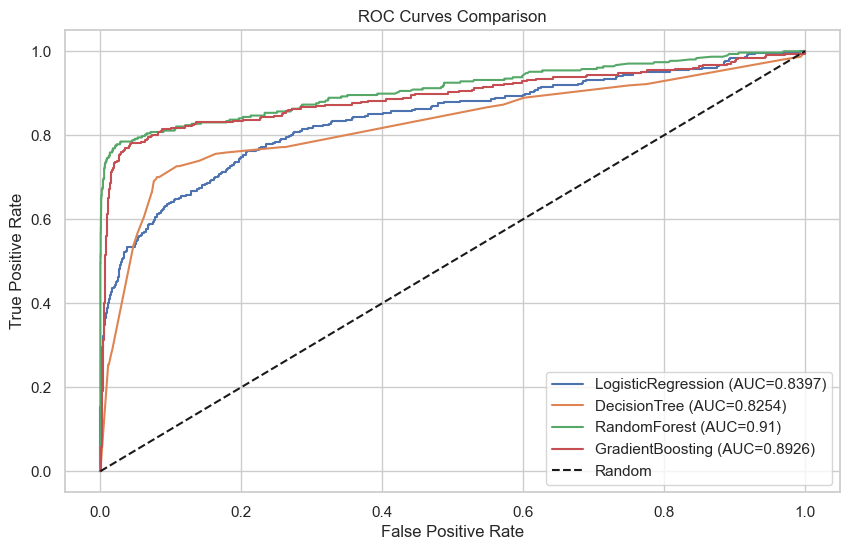

Матрица ошибок для лучшей модели: RandomForest


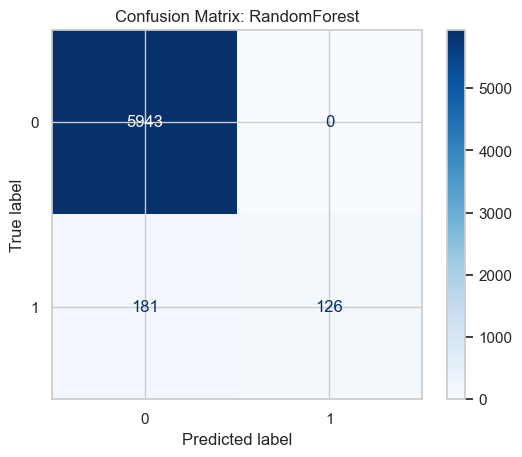

In [ ]:
# Сводная таблица
results_df = pd.DataFrame(metrics_storage).T.sort_values("roc_auc", ascending=False)
print("Финальные результаты на Test:")
display(results_df)

# График ROC-кривых
plt.figure(figsize=(10, 6))

models_dict = {
    "LogisticRegression": y_prob_lr,
    "DecisionTree": y_prob_dt,
    "RandomForest": y_prob_rf,
    "GradientBoosting": y_prob_gb
}

for name, y_prob in models_dict.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_val = metrics_storage[name]['roc_auc']
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val})")

plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend()
plt.savefig("artifacts/figures/roc_curves.png")
plt.show()

# Confusion Matrix для лучшей модели
best_model_name = results_df.index[0]
print(f"Матрица ошибок для лучшей модели: {best_model_name}")
cm = confusion_matrix(y_test, (models_dict[best_model_name] > 0.5).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix: {best_model_name}")
plt.savefig("artifacts/figures/confusion_matrix.png")
plt.show()

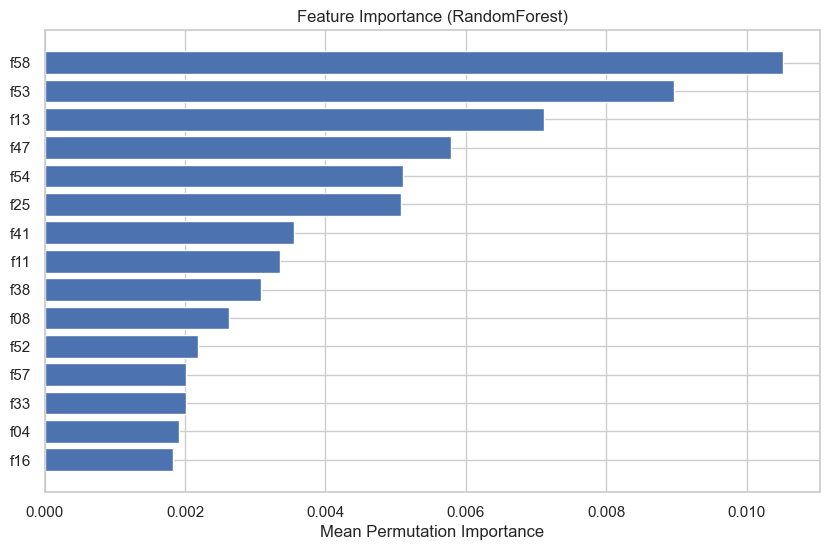

In [ ]:
# Permutation Importance для лучшей модели

if best_model_name == "GradientBoosting":
    target_model = best_gb
elif best_model_name == "RandomForest":
    target_model = best_rf
else:
    target_model = best_dt

r = permutation_importance(target_model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)

sorted_idx = r.importances_mean.argsort()[::-1][:15] # Топ-15

plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx][::-1], r.importances_mean[sorted_idx][::-1])
plt.xlabel("Mean Permutation Importance")
plt.title(f"Feature Importance ({best_model_name})")
plt.savefig("artifacts/figures/feature_importance.png")
plt.show()

In [ ]:
# Сохраняем метрики
with open("artifacts/metrics_test.json", "w") as f:
    json.dump(metrics_storage, f, indent=4)

# Сохраняем параметры поиска
with open("artifacts/search_summaries.json", "w") as f:
    json.dump(search_summaries, f, indent=4)

# Сохраняем лучшую модель
joblib.dump(target_model, "artifacts/best_model.joblib")

# Метаданные лучшей модели
best_meta = {
    "model_name": best_model_name,
    "metrics": metrics_storage[best_model_name],
    "params": search_summaries.get(best_model_name, {}).get("best_params")
}
with open("artifacts/best_model_meta.json", "w") as f:
    json.dump(best_meta, f, indent=4)

print("Успешно сохранено в папку artifacts/")

Успешно сохранено в папку artifacts/
